In [7]:
# !pip3 install two-sample-binomial
# !pip3 install multiple-hypothesis-testing
# !pip3 install lifelines
# !pip3 install multiHGtest

from multitest import MultiTest
from test_gene_expression import two_groups_table
from illustrate_gene_expression_survival_curves import illustrate_survival_curve_time2event, plot_survival_curve_time2event
from multiHGtest import testHG_dashboard, HCHGtest

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl
plt.rcParams['figure.figsize'] =  [8, 6]
mpl.style.use('ggplot')


from survival import evaluate_test_stats, multi_pvals
import logging
from tqdm import tqdm

from SurvSet.data import SurvLoader
from test_gene_expression import test_gene

In [2]:

logging.info("Finding relevant datasets...")
loader = SurvLoader()
lo_datasets = []
MIN_MAX_EVENTS = 15

lo_ds_names = loader.df_ds.ds # List of available datasets and meta-info
acc = {}
logging.info(f"Datasets with at least {MIN_MAX_EVENTS} events in at least one time interval:")
for ds_name in lo_ds_names:
    df, ref = loader.load_dataset(ds_name=ds_name).values()
    if 'time2' in df.columns:
        df['diff'] = df['time2'] - df['time']
    else:
        df['diff'] = df['time']
    acc[ds_name] = df.groupby(['diff'])['event'].sum().max()
    if acc[ds_name] >= MIN_MAX_EVENTS:
        logging.info(f"{ds_name}")
        lo_datasets.append(ds_name)
        #df.groupby(['diff']).count()['event'].hist(bins=np.arange(30))
        #plt.title(f"{ds_name}")
        #plt.show()


INFO:root:Finding relevant datasets...
INFO:root:Datasets with at least 15 events in at least one time interval:
INFO:root:LeukSurv
INFO:root:UnempDur
INFO:root:Aids2
INFO:root:Z243
INFO:root:Dialysis
INFO:root:support2
INFO:root:vlbw
INFO:root:prostateSurvival
INFO:root:acath
INFO:root:follic
INFO:root:dataOvarian1
INFO:root:Rossi
INFO:root:Unemployment
INFO:root:prostate
INFO:root:grace


## Illustrate Curves

In [3]:

def illustrate_survival_curve_time2event(df_time2event,
                                        stbl=True, # type of HC stat
                               show_HCT=True, randomize_HC=False,
                               show_stats_in_title=True, flip_sides=False):
        
     # to table representation
    dfg = two_groups_table(df_time2event, 'group')

    Nt1, Nt2 = dfg['at_risk:0'].values, dfg['at_risk:1'].values
    Ot1, Ot2 = dfg['observed:0'].values, dfg['observed:1'].values

    stats = evaluate_test_stats(Nt1, Nt2, Ot1, Ot2, stbl=stbl, randomize=randomize_HC)
    stats_rev = evaluate_test_stats(Nt2, Nt1, Ot2, Ot1, stbl=stbl, randomize=randomize_HC)
    if flip_sides and (stats['hc_greater'] < stats_rev['hc_greater']): # reverse groups
        df_time2event.loc[:, 'group'] = df_time2event['group'].apply(lambda x : 1 - x) # flip groups
        dfg = two_groups_table(df_time2event, 'group')
        temp = stats
        stats = stats_rev
        stats_rev = temp
        Nt1, Nt2 = dfg['at_risk:0'].values, dfg['at_risk:1'].values
        Ot1, Ot2 = dfg['observed:0'].values, dfg['observed:1'].values
        logging.info("Flipped sides")
        
    plot_survival_curve_time2event(df_time2event)
    
    #pvals = multi_pvals(Nt1, Nt2, Ot1, Ot2, randomize=False)
    #pvals_rev = multi_pvals(Nt2, Nt1, Ot2, Ot1, randomize=False)
    
    dfg, statsHG = testHG_dashboard(Nt1, Nt2, Ot1, Ot2, 
                                    randomize=False, stbl=True, alternative='greater')

    np.testing.assert_almost_equal(statsHG['hc'], stats['hc_greater'])

    df_disp = dfg[dfg.HCT]
    if show_HCT:
        xvals = dfg.index[:len(df_disp)]
        yvals = np.ones_like(xvals)
        plt.bar(xvals, yvals, color='k', alpha=.2, width=.5)
        
    if show_stats_in_title:
        stats_str = f"HC={np.round(stats['hc_greater'],2)}, Log-rank={np.round(stats['log_rank_greater'],2)}"
        plt.title(stats_str)
    plt.ylabel('Proportion', fontsize=16)
    plt.xlabel(r'Duration', fontsize=16)

    return df_disp, dfg


In [6]:
import json

with open('survset_critvals.json', 'r') as fp:
    critvals = json.load(fp)

len(critvals)

15

In [8]:
MAX_CATEGORIES = 5 # don't split if 
FRAC_LOW = 0.1
FRAC_HIGH = 0.9
lo_stats = ['hc_greater', 'log_rank_greater', 'log_rank_pval_greater',
            'hc_greater_rev', 'log_rank_greater_rev', 'log_rank_pval_greater_rev',
            'fisher_greater', 'min_p_greater', 'fisher_greater_rev', 'min_p_greater_rev',
            'logrank_lifelines_None',
            'logrank_lifelines_wilcoxon', 'logrank_lifelines_tarone-ware',
            'logrank_lifelines_peto',
            'logrank_lifelines_fleming-harrington55', 'logrank_lifelines_fleming-harrington11', 'logrank_lifelines_fleming-harrington01'
            ]

res = []
for ds_name in tqdm(lo_datasets):
    df, ref = loader.load_dataset(ds_name=ds_name).values()
    lo_facs = df.filter(like='fac_').columns
    for fac in lo_facs:
        # feature to partition
        lo_values = df[fac].unique()
        no_values = len(lo_values)
        if (no_values > MAX_CATEGORIES) or (no_values == 1): #
            continue
        if no_values == 2:
            lo_values = lo_values[:1]
        for value in lo_values:
            df['group'] = (df[fac] == value) + 0
            if (df['group'].mean() < FRAC_LOW) or (df['group'].mean() > FRAC_HIGH):
                continue
            r = test_gene(df, 'group', T=0, stbl=True, randomize=False)
            r['name'] = f"{ds_name}:{fac}:{value}"
            for stat_name in lo_stats:
                r[f"critval_{stat_name}"] = critvals[ds_name][stat_name]
            # r['critval_hc'] = critvals[ds_name]['hc_greater']
            # r['critval_lr'] = critvals[ds_name]['log_rank_greater']
            res.append(r)
df_res = pd.concat(res, axis=0)

100%|██████████| 15/15 [00:25<00:00,  1.70s/it]


In [9]:
# findi which instances exceeded the critical value
logging.info("For each instance, find all test statistics exceeding their critical values")
discoveries = {}
for stat_name in lo_stats:
    discoveries[stat_name] = (df_res[stat_name] > df_res['critval_'+stat_name])

INFO:root:For each instance, find all test statistics exceeding their critical values


In [17]:
lo_stats

['hc_greater',
 'log_rank_greater',
 'log_rank_pval_greater',
 'hc_greater_rev',
 'log_rank_greater_rev',
 'log_rank_pval_greater_rev',
 'fisher_greater',
 'min_p_greater',
 'fisher_greater_rev',
 'min_p_greater_rev',
 'logrank_lifelines_None',
 'logrank_lifelines_wilcoxon',
 'logrank_lifelines_tarone-ware',
 'logrank_lifelines_peto',
 'logrank_lifelines_fleming-harrington55',
 'logrank_lifelines_fleming-harrington11',
 'logrank_lifelines_fleming-harrington01']

In [36]:
group2

['logrank_lifelines_None',
 'logrank_lifelines_wilcoxon',
 'logrank_lifelines_tarone-ware',
 'logrank_lifelines_peto',
 'logrank_lifelines_fleming-harrington55',
 'logrank_lifelines_fleming-harrington11',
 'logrank_lifelines_fleming-harrington01']

In [44]:
logging.info("Report on the number of discoveries in every group")

#group1 = ['hc_greater', 'hc_greater_rev']
for group1 in [['hc_greater', 'hc_greater_rev'], ['logrank_lifelines_None'], ['logrank_lifelines_wilcoxon'], ['logrank_lifelines_wilcoxon'],
               ['logrank_lifelines_tarone-ware'], ['logrank_lifelines_peto']]:
    print(f"\t{group1}")    
    to_exclude = ['fisher_greater', 'min_p_greater', 'fisher_greater_rev', 'min_p_greater_rev',
                'log_rank_pval_greater', 'log_rank_pval_greater_rev',
                'logrank_lifelines_fleming-harrington55',
                'logrank_lifelines_fleming-harrington11',
                'logrank_lifelines_fleming-harrington01',
                'log_rank_greater', 'log_rank_greater_rev',
                ]

    group2 = [s for s in lo_stats if s not in (group1 + to_exclude)]
    print(f"\t{group2}")
    #group2 = ['logrank_lifelines_None', 'logrank_lifelines_wilcoxon', 'logrank_lifelines_tarone-ware', 'logrank_lifelines_peto', 
            #'logrank_lifelines_fleming-harrington55', 'logrank_lifelines_fleming-harrington11', 'logrank_lifelines_fleming-harrington01'
    #]
    group_neutral = [s for s in lo_stats if s not in (group1 + group2 + to_exclude)]

    discoveries1 = [False] * len(df_res)
    discoveries2 = [False] * len(df_res)

    for sn in group1:
        discoveries1 = discoveries1 | discoveries[sn]
        
    for sn in group2:
        discoveries2 = discoveries2 | discoveries[sn]

    # for sn in group_neutral:
    #     discoveriesN = discoveriesN | discoveries[sn]


    print("Group1: ", group1)
    print("Group2: ", group2)
    print("Group N: ", group_neutral)
    print("Neither: ", to_exclude)

    print("Number of discoveries in Group1: ", np.sum(discoveries1))
    print("Number of discoveries in Group2: ", np.sum(discoveries2))
    print("Number of joint 1&2 discoveries: ", np.sum(discoveries1 & discoveries2))
    print("Number of unique discoveries 1: ", np.sum(discoveries1 & ~discoveries2))
    print("Number of unique discoveries 2: ", np.sum(discoveries2 & ~discoveries1))

    #print("Number of unique discoveries 1: ", np.sum(discoveries1 & ~discoveries2 & ~discoveriesN))
    #print("Number of unique discoveries 2: ", np.sum(discoveries2 & ~discoveries1 & ~discoveriesN))
    
    print("Discovered by Group1 but not Group2: (<dataset>:<factor>:<value>)")
    print(df_res['name'][discoveries1 & ~discoveries2].values)

INFO:root:Report on the number of discoveries in every group


	['hc_greater', 'hc_greater_rev']
	['logrank_lifelines_None', 'logrank_lifelines_wilcoxon', 'logrank_lifelines_tarone-ware', 'logrank_lifelines_peto']
Group1:  ['hc_greater', 'hc_greater_rev']
Group2:  ['logrank_lifelines_None', 'logrank_lifelines_wilcoxon', 'logrank_lifelines_tarone-ware', 'logrank_lifelines_peto']
Group N:  []
Neither:  ['fisher_greater', 'min_p_greater', 'fisher_greater_rev', 'min_p_greater_rev', 'log_rank_pval_greater', 'log_rank_pval_greater_rev', 'logrank_lifelines_fleming-harrington55', 'logrank_lifelines_fleming-harrington11', 'logrank_lifelines_fleming-harrington01', 'log_rank_greater', 'log_rank_greater_rev']
Number of discoveries in Group1:  50
Number of discoveries in Group2:  60
Number of joint 1&2 discoveries:  45
Number of unique discoveries 1:  5
Number of unique discoveries 2:  15
Discovered by Group1 but not Group2: (<dataset>:<factor>:<value>)
['Z243:fac_Sex:M' 'vlbw:fac_pda:0' 'prostateSurvival:fac_ageGroup:75-79'
 'follic:fac_ch:N' 'Unemployment:fa

In [12]:
~discoveriesN

TypeError: bad operand type for unary ~: 'list'

In [25]:
discoveriesN[sn]

TypeError: list indices must be integers or slices, not str

In [22]:
group_neutral

['log_rank_pval_greater',
 'log_rank_pval_greater_rev',
 'logrank_lifelines_None',
 'logrank_lifelines_wilcoxon',
 'logrank_lifelines_tarone-ware',
 'logrank_lifelines_peto',
 'logrank_lifelines_fleming-harrington55',
 'logrank_lifelines_fleming-harrington11',
 'logrank_lifelines_fleming-harrington01']

{'hc': -0.2664382000044443, 'fisher': 196.82889353541572, 'fisher_pval': 0.9808630532642668, 'minP': 0.011233591670114524}
0       True
1       True
2      False
3      False
4       True
       ...  
115    False
116    False
117    False
118    False
119    False
Name: HCT, Length: 120, dtype: bool


ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (4,) and arg 1 with shape (120,).

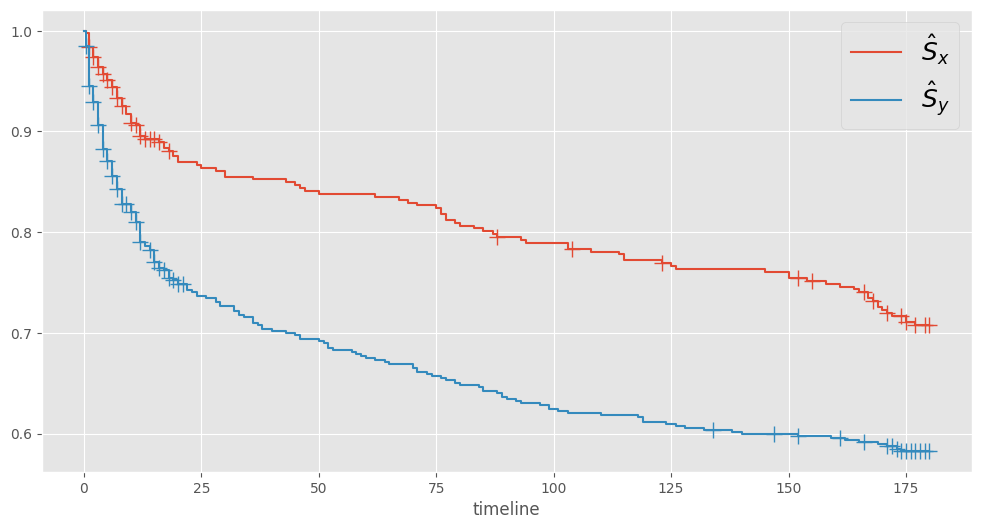

In [314]:
dfp_HCT, dfp = illustrate_survival_curve_time2event(df, flip_sides=True, show_stats_in_title=True)
plt.show()
print(len(dfp_HCT))


HERE!! understand why disagreement between methods on Nt1 and Nt2